In [223]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from tqdm import tqdm_notebook as tqdm

import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error
plt.rcParams['figure.figsize'] = (16, 4)

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import pmdarima as pm

from pmdarima.pipeline import Pipeline
from pmdarima.preprocessing import BoxCoxEndogTransformer

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)   
warnings.filterwarnings("ignore") # specify to ignore warning messages

import utils

In [224]:
farm1 = pd.read_csv('data/wf1_data.csv')
farm2 = pd.read_csv('data/wf2_data.csv')
farm3 = pd.read_csv('data/wf3_data.csv')

farm1['date'] = pd.to_datetime(farm1['date'], format = '%Y%m%d%H')
farm2['date'] = pd.to_datetime(farm2['date'], format = '%Y%m%d%H')
farm3['date'] = pd.to_datetime(farm3['date'], format = '%Y%m%d%H')

farm1 = farm1.set_index('date').sort_index()
farm2 = farm2.set_index('date').sort_index()
farm3 = farm3.set_index('date').sort_index()
farm3.head()

,wp,ws
date,,
2009-07-01 01:00:00,0.105,3.81
2009-07-01 02:00:00,0.033,3.68
2009-07-01 03:00:00,0.022,3.66
2009-07-01 04:00:00,0.039,3.70
2009-07-01 06:00:00,0.105,3.66


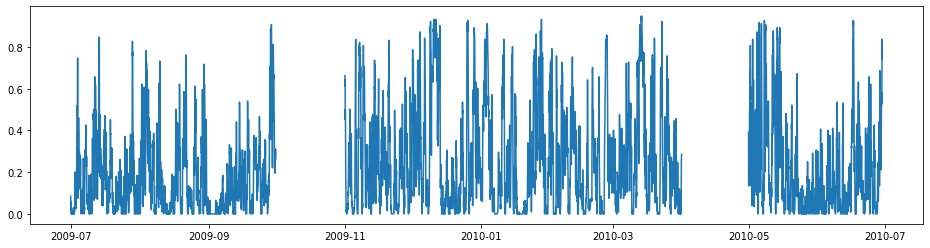

In [61]:
#plot
plt.plot(farm1.wp, label='farm1 wp');
# plt.plot(farm1.ws, label='farm1 ws');

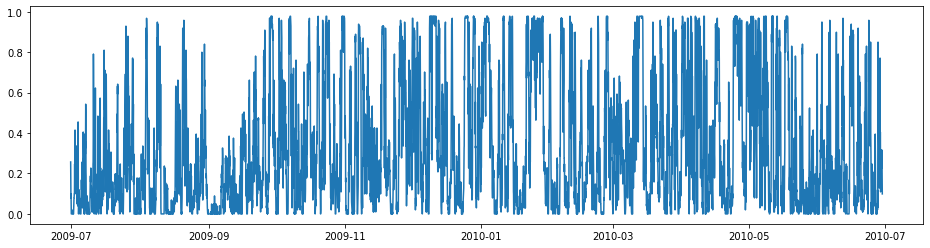

In [36]:
plt.plot(farm2.wp, label='farm2')

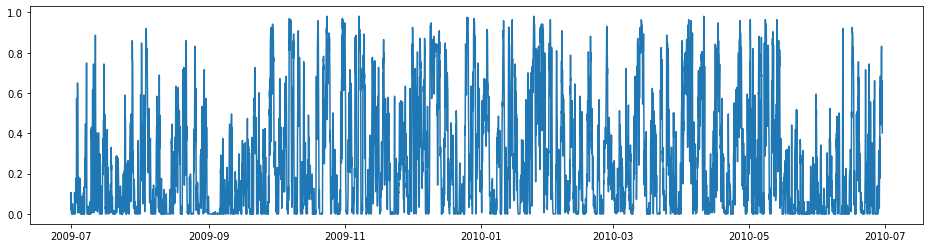

In [215]:
plt.plot(farm3.wp, label='farm3')

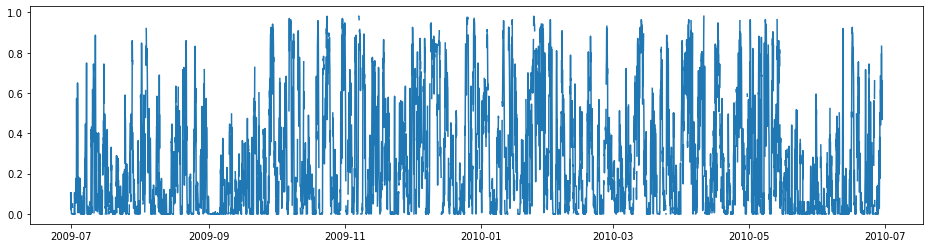

In [216]:
plt.plot(farm3.wp.resample('h').mean(), label='farm3')

In [54]:
farm1.shape #(8759, 2)
farm2.shape #(8759, 2)
farm3.shape #(7994, 2)


farm1.loc[:'29 jun 2010'].isnull().sum()
# wp    1464
# ws       0

farm2.loc[:'29 jun 2010'].isnull().sum()
# wp    24
# ws     0

farm3.loc[:'29 jun 2010'].isnull().sum()
# wp     0
# ws     0
# dtype: int64

wp    1464
ws       0
dtype: int64

In [56]:
#missing dates/hours
farm1.loc[:'29 jun 2010'].resample('h').mean().isnull().sum()#1464
farm2.loc[:'29 jun 2010'].resample('h').mean().isnull().sum()#0
farm3.loc[:'29 jun 2010'].resample('h').mean().isnull().sum()#765

wp    765
ws    765
dtype: int64

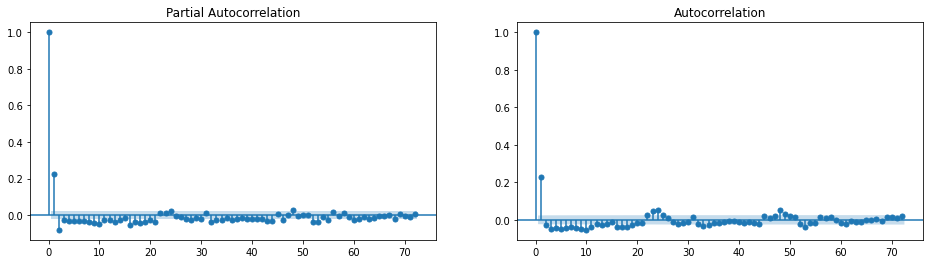

In [62]:
#Farm1
fig, ax = plt.subplots(1,2)
plot_pacf(farm1['wp'].diff().dropna(), alpha=.05, lags=72, ax=ax[0], method='ols')  
plot_acf(farm1['wp'].diff().dropna(), alpha=.05, lags=72, ax=ax[1])  
plt.show()

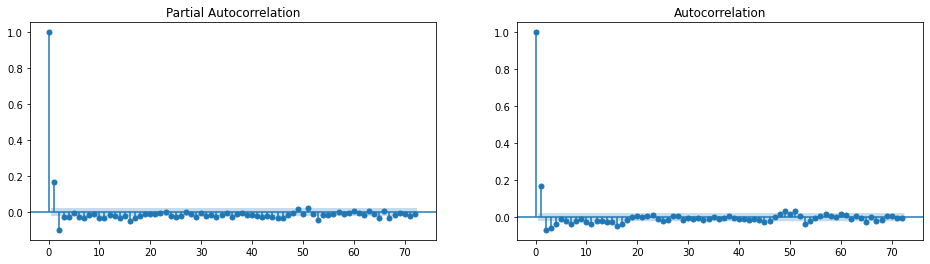

In [63]:
#Farm2
fig, ax = plt.subplots(1,2)
plot_pacf(farm2['wp'].diff().dropna(), alpha=.05, lags=72, ax=ax[0], method='ols')  
plot_acf(farm2['wp'].diff().dropna(), alpha=.05, lags=72, ax=ax[1])  
plt.show()

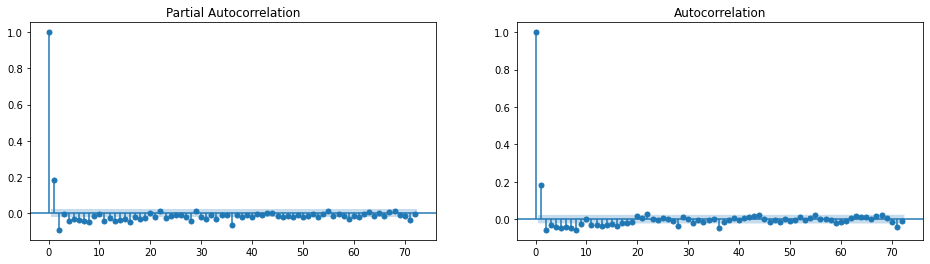

In [64]:
#Farm3
fig, ax = plt.subplots(1,2)
plot_pacf(farm3['wp'].diff().dropna(), alpha=.05, lags=72, ax=ax[0], method='ols')  
plot_acf(farm3['wp'].diff().dropna(), alpha=.05, lags=72, ax=ax[1])  
plt.show()

In [69]:
#BaseLine Model: from may2010

farm1_baseline = farm1.loc['may 2010':].dropna()#(1440, 2)
farm2_baseline = farm2.loc['may 2010':].dropna()#(1440, 2)
farm3_baseline = farm3.loc['may 2010':].dropna()#(1315, 2) - 125 missing values

In [73]:
farm3_baseline.resample('h').mean().isnull().sum()

wp    125
ws    125
dtype: int64

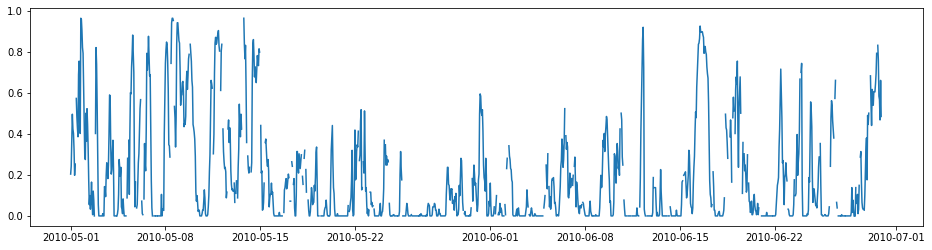

In [81]:
farm3_baseline = farm3_baseline.resample('h').mean()
plt.plot(farm3_baseline.wp)

In [139]:
# plt.plot(farm3_baseline.ws)

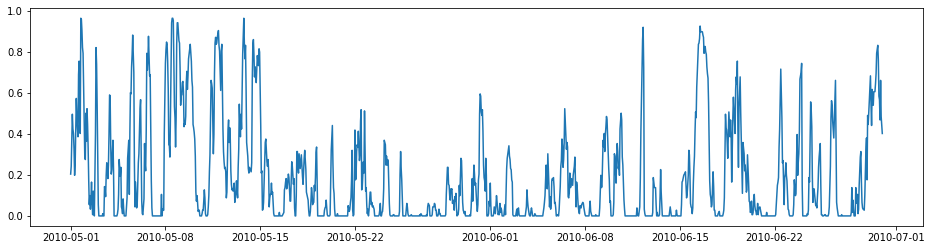

In [84]:
farm3_baseline['wp'] = farm3_baseline.wp.interpolate()
plt.plot(farm3_baseline.wp)

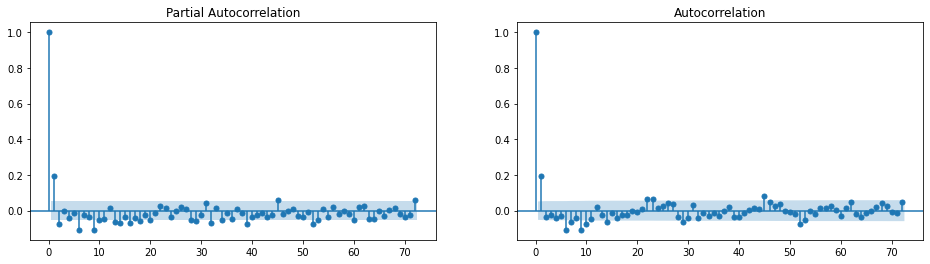

In [85]:
#Farm1
fig, ax = plt.subplots(1,2)
plot_pacf(farm1_baseline['wp'].diff().dropna(), alpha=.05, lags=72, ax=ax[0], method='ols')  
plot_acf(farm1_baseline['wp'].diff().dropna(), alpha=.05, lags=72, ax=ax[1])  
plt.show()

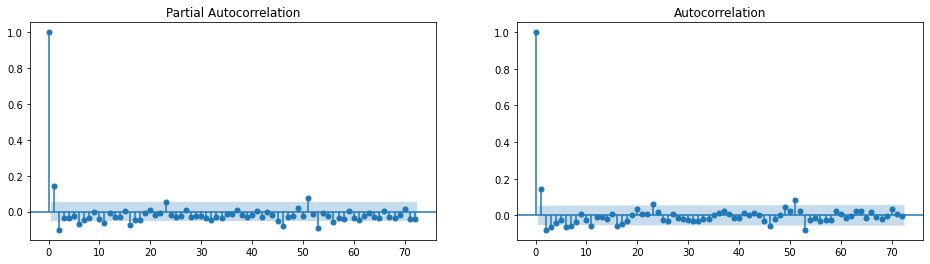

In [86]:
#Farm2
fig, ax = plt.subplots(1,2)
plot_pacf(farm2_baseline['wp'].diff().dropna(), alpha=.05, lags=72, ax=ax[0], method='ols')  
plot_acf(farm2_baseline['wp'].diff().dropna(), alpha=.05, lags=72, ax=ax[1])  
plt.show()

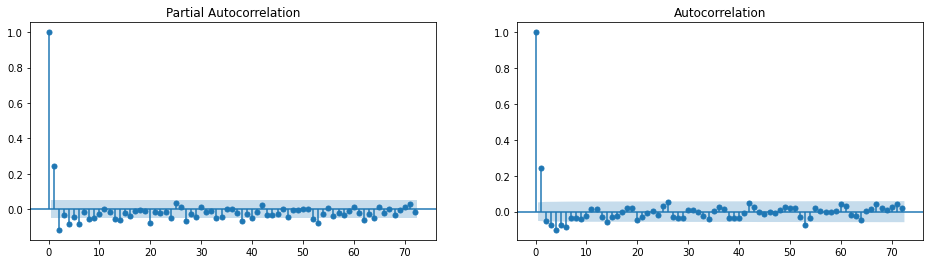

In [87]:
#Farm3
fig, ax = plt.subplots(1,2)
plot_pacf(farm3_baseline['wp'].diff().dropna(), alpha=.05, lags=72, ax=ax[0], method='ols')  
plot_acf(farm3_baseline['wp'].diff().dropna(), alpha=.05, lags=72, ax=ax[1])  
plt.show()

In [93]:
#split between train e test set

farm1_baseline_train = farm1_baseline[:-24].drop('ws', axis=1)
farm1_baseline_test  = farm1_baseline[-24:].drop('ws', axis=1)

farm2_baseline_train = farm2_baseline[:-24].drop('ws', axis=1)
farm2_baseline_test  = farm2_baseline[-24:].drop('ws', axis=1)

farm3_baseline_train = farm3_baseline[:-24].drop('ws', axis=1)
farm3_baseline_test  = farm3_baseline[-24:].drop('ws', axis=1)

farm1_baseline_train.head()

,wp
date,
2010-05-01 00:00:00,0.391
2010-05-01 01:00:00,0.135
2010-05-01 02:00:00,0.170
2010-05-01 03:00:00,0.236
2010-05-01 04:00:00,0.391


In [136]:
sarimax_pipeline_f1 = Pipeline([
    ('boxcox', BoxCoxEndogTransformer(lmbda2=1e-6)),
    ('arima', pm.AutoARIMA(trace=True,
                           suppress_warnings=True,
                           m=2
                          )
    )
])

sarimax_pipeline_f1.fit(farm1_baseline_train)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[2] intercept   : AIC=1178.529, Time=2.17 sec
 ARIMA(0,1,0)(0,0,0)[2] intercept   : AIC=1229.183, Time=0.16 sec
 ARIMA(1,1,0)(1,0,0)[2] intercept   : AIC=1188.504, Time=0.25 sec
 ARIMA(0,1,1)(0,0,1)[2] intercept   : AIC=1187.549, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[2]             : AIC=1227.183, Time=0.06 sec
 ARIMA(1,1,1)(0,0,1)[2] intercept   : AIC=1189.226, Time=1.20 sec
 ARIMA(1,1,1)(1,0,0)[2] intercept   : AIC=1190.091, Time=0.60 sec
 ARIMA(1,1,1)(2,0,1)[2] intercept   : AIC=1180.478, Time=3.16 sec
 ARIMA(1,1,1)(1,0,2)[2] intercept   : AIC=1180.474, Time=3.65 sec
 ARIMA(1,1,1)(0,0,0)[2] intercept   : AIC=1189.473, Time=0.46 sec
 ARIMA(1,1,1)(0,0,2)[2] intercept   : AIC=1185.774, Time=1.58 sec
 ARIMA(1,1,1)(2,0,0)[2] intercept   : AIC=1186.726, Time=1.33 sec
 ARIMA(1,1,1)(2,0,2)[2] intercept   : AIC=1182.465, Time=4.62 sec
 ARIMA(0,1,1)(1,0,1)[2] intercept   : AIC=1176.607, Time=1.28 sec
 ARIMA(0,1,1)(1,0,0)[2] intercept

Pipeline(steps=[('boxcox', BoxCoxEndogTransformer(lmbda2=1e-06)),
                ('arima', AutoARIMA(m=2, suppress_warnings=True, trace=True))])

In [137]:
pred_f1 = sarimax_pipeline_f1.predict(24)
mean_absolute_error(pred_f1,farm1_baseline_test)


0.1770751388507077

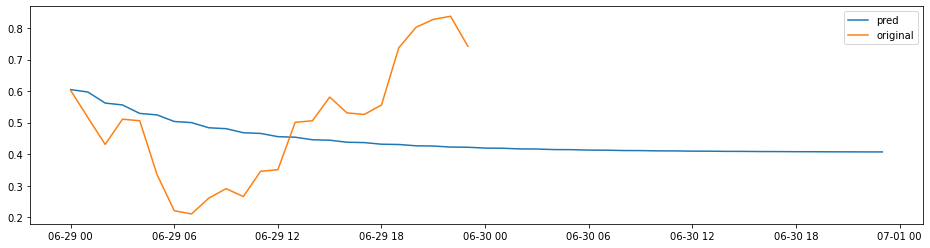

In [138]:
pred_f1_1day = sarimax_pipeline_f1.predict(48)

plt.plot(pd.Series(pred_f1_1day, index=farm1[-48:].index), label='pred')
plt.plot(farm1[-48:].wp, label='original')
plt.legend();

In [132]:
# plt.plot(pd.Series(pred_f1, index=farm1_baseline_test.index), label='pred')
# plt.plot(farm1_baseline_test, label='original')
# plt.legend();

In [108]:
sarimax_pipeline_f2 = Pipeline([
    ('boxcox', BoxCoxEndogTransformer(lmbda2=1e-6)),
    ('arima', pm.AutoARIMA(trace=True,
                           suppress_warnings=True,
                           m=3
                          )
    )
])

sarimax_pipeline_f2.fit(farm2_baseline_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[3] intercept   : AIC=1156.663, Time=5.48 sec
 ARIMA(0,1,0)(0,0,0)[3] intercept   : AIC=1219.615, Time=0.17 sec
 ARIMA(1,1,0)(1,0,0)[3] intercept   : AIC=1195.640, Time=0.32 sec
 ARIMA(0,1,1)(0,0,1)[3] intercept   : AIC=1188.531, Time=0.48 sec
 ARIMA(0,1,0)(0,0,0)[3]             : AIC=1217.615, Time=0.10 sec
 ARIMA(2,1,2)(0,0,1)[3] intercept   : AIC=1149.119, Time=4.69 sec
 ARIMA(2,1,2)(0,0,0)[3] intercept   : AIC=inf, Time=1.83 sec
 ARIMA(2,1,2)(0,0,2)[3] intercept   : AIC=1147.815, Time=7.03 sec
 ARIMA(2,1,2)(1,0,2)[3] intercept   : AIC=1150.384, Time=7.21 sec
 ARIMA(1,1,2)(0,0,2)[3] intercept   : AIC=1127.119, Time=6.55 sec
 ARIMA(1,1,2)(0,0,1)[3] intercept   : AIC=inf, Time=4.38 sec
 ARIMA(1,1,2)(1,0,2)[3] intercept   : AIC=1147.557, Time=7.96 sec
 ARIMA(1,1,2)(1,0,1)[3] intercept   : AIC=inf, Time=5.10 sec
 ARIMA(0,1,2)(0,0,2)[3] intercept   : AIC=1174.758, Time=1.50 sec
 ARIMA(1,1,1)(0,0,2)[3] intercept   : AIC=1179.8

Pipeline(steps=[('boxcox', BoxCoxEndogTransformer(lmbda2=1e-06)),
                ('arima', AutoARIMA(m=3, suppress_warnings=True, trace=True))])

In [110]:
pred_f2 = sarimax_pipeline_f2.predict(24)
mean_absolute_error(pred_f2,farm2_baseline_test)

0.09577596411339477

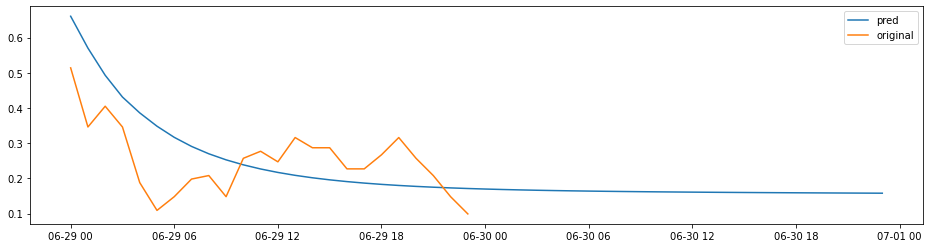

In [131]:
pred_f2_1day = sarimax_pipeline_f2.predict(48)

plt.plot(pd.Series(pred_f2_1day, index=farm2[-48:].index), label='pred')
plt.plot(farm2[-48:].wp, label='original')
plt.legend();

In [130]:
# plt.plot(pd.Series(pred_f2, index=farm2_baseline_test.index), label='pred')
# plt.plot(farm2_baseline_test, label='original')
# plt.legend();

In [98]:
sarimax_pipeline_f3 = Pipeline([
    ('boxcox', BoxCoxEndogTransformer(lmbda2=1e-6)),
    ('arima', pm.AutoARIMA(trace=True,
                           suppress_warnings=True,
                           m=2
                          )
    )
])

sarimax_pipeline_f3.fit(farm3_baseline_train)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,1,1)[2] intercept   : AIC=inf, Time=2.23 sec
 ARIMA(0,0,0)(0,1,0)[2] intercept   : AIC=4963.878, Time=0.04 sec
 ARIMA(1,0,0)(1,1,0)[2] intercept   : AIC=4389.761, Time=0.25 sec
 ARIMA(0,0,1)(0,1,1)[2] intercept   : AIC=inf, Time=0.59 sec
 ARIMA(0,0,0)(0,1,0)[2]             : AIC=4961.878, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[2] intercept   : AIC=4588.515, Time=0.12 sec
 ARIMA(1,0,0)(2,1,0)[2] intercept   : AIC=4280.706, Time=0.59 sec
 ARIMA(1,0,0)(2,1,1)[2] intercept   : AIC=inf, Time=3.64 sec
 ARIMA(1,0,0)(1,1,1)[2] intercept   : AIC=inf, Time=1.84 sec
 ARIMA(0,0,0)(2,1,0)[2] intercept   : AIC=4932.239, Time=0.21 sec
 ARIMA(1,0,1)(2,1,0)[2] intercept   : AIC=inf, Time=1.15 sec
 ARIMA(0,0,1)(2,1,0)[2] intercept   : AIC=inf, Time=0.86 sec
 ARIMA(1,0,0)(2,1,0)[2]             : AIC=4278.707, Time=0.23 sec
 ARIMA(1,0,0)(1,1,0)[2]             : AIC=4387.761, Time=0.16 sec
 ARIMA(1,0,0)(2,1,1)[2]             : AIC=inf, Time=1.35 sec
 A

Pipeline(steps=[('boxcox', BoxCoxEndogTransformer(lmbda2=1e-06)),
                ('arima', AutoARIMA(m=2, suppress_warnings=True, trace=True))])

In [116]:
pred_f3 = sarimax_pipeline_f3.predict(24)
mean_absolute_error(pred_f3,farm3_baseline_test)

0.14726426682721716

In [117]:
pred_f3_1day = sarimax_pipeline_f3.predict(48)

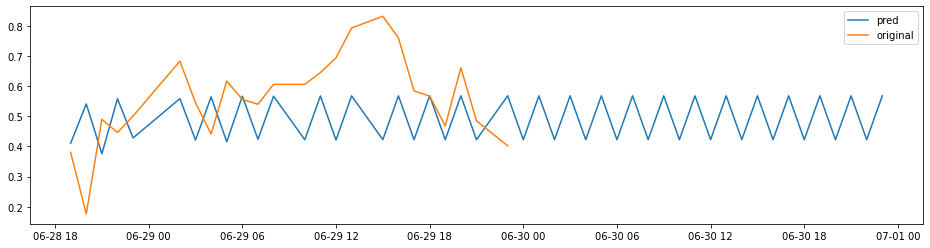

In [129]:
plt.plot(pd.Series(pred_f3_1day, index=farm3[-48:].index), label='pred')
plt.plot(farm3[-48:].wp, label='original')
plt.legend();

In [156]:
submition1 = pd.Series(pd.concat([pd.Series(pred_f1_1day[-24:]), pd.Series(pred_f2_1day[-24:]), pd.Series(pred_f3_1day[-24:])]),name='value')


In [169]:
submition1.to_csv('data/baselinesubmission.csv', index=False)

In [166]:
submition1.values

array([0.41946464, 0.41900006, 0.41686886, 0.41649515, 0.41478008,
       0.41447922, 0.41309798, 0.4128556 , 0.41174253, 0.41154716,
       0.41064975, 0.41049219, 0.40976836, 0.40964126, 0.40905725,
       0.40895468, 0.40848335, 0.40840057, 0.4080201 , 0.40795327,
       0.40764609, 0.40759213, 0.4073441 , 0.40730052, 0.16969916,
       0.16839139, 0.16724588, 0.16623874, 0.16534974, 0.16456168,
       0.16385996, 0.16323213, 0.16266758, 0.16215726, 0.16169343,
       0.16126947, 0.16087974, 0.16051938, 0.16018425, 0.15987079,
       0.15957595, 0.15929712, 0.15903206, 0.15877883, 0.1585358 ,
       0.15830154, 0.15807484, 0.15785465, 0.42235701, 0.56785846,
       0.42233708, 0.56786315, 0.42236522, 0.56786139, 0.42235862,
       0.56786377, 0.42235568, 0.56786436, 0.42235993, 0.56786405,
       0.42235884, 0.56786439, 0.42235841, 0.56786447, 0.42235905,
       0.56786441, 0.42235887, 0.56786446, 0.42235881, 0.56786447,
       0.4223589 , 0.56786446])

### Adding exogenous variable in the previous models

In [176]:
#wind speed

farm1_baseline.ws.isnull().sum()#0
farm2_baseline.ws.isnull().sum()#0
farm3_baseline.ws.isnull().sum()#125

125

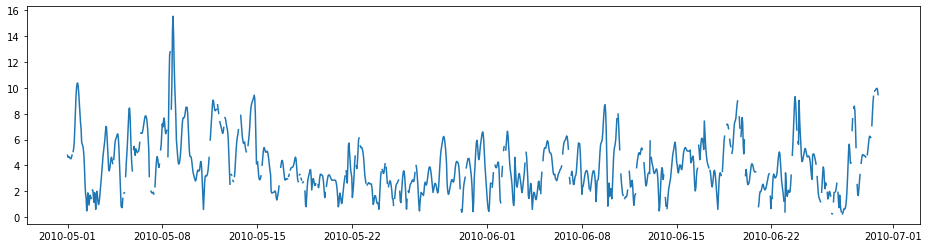

In [177]:
plt.plot(farm3_baseline.ws)

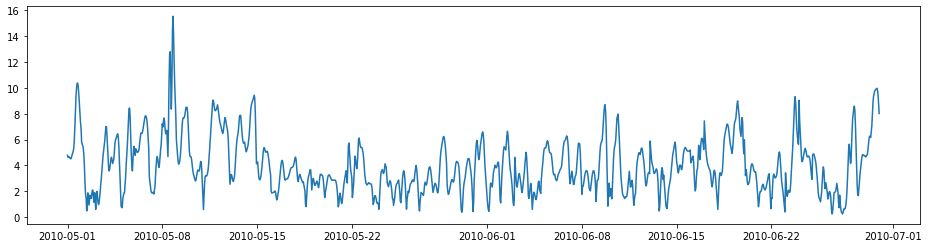

In [178]:
farm3_baseline['ws'] = farm3_baseline.ws.interpolate()
plt.plot(farm3_baseline.ws)

In [179]:
#split exogeneous between train e test set

farm1_exog_train = farm1_baseline[:-24].drop('wp', axis=1)
farm1_exog_test  = farm1_baseline[-24:].drop('wp', axis=1)

farm2_exog_train = farm2_baseline[:-24].drop('wp', axis=1)
farm2_exog_test  = farm2_baseline[-24:].drop('wp', axis=1)

farm3_exog_train = farm3_baseline[:-24].drop('wp', axis=1)
farm3_exog_test  = farm3_baseline[-24:].drop('wp', axis=1)

farm3_exog_train.head()

,ws
date,
2010-05-01 00:00:00,4.78
2010-05-01 01:00:00,4.62
2010-05-01 02:00:00,4.65
2010-05-01 03:00:00,4.66
2010-05-01 04:00:00,4.59


In [206]:
sarimax_pipeline_exog_f1 = Pipeline([  #The boxcox transform has been removed because it messes with the exogenous input
    ('arima', pm.AutoARIMA(trace=True,
                           suppress_warnings=True,
                           m=2, 
                           method='nm',
                           maxiter=20,
                           
                          )
    )
])

sarimax_pipeline_exog_f1.fit(farm1_baseline_train,farm1_exog_train)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[2] intercept   : AIC=-3143.566, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[2] intercept   : AIC=-3104.459, Time=0.13 sec
 ARIMA(1,1,0)(1,0,0)[2] intercept   : AIC=-3142.207, Time=0.18 sec
 ARIMA(0,1,1)(0,0,1)[2] intercept   : AIC=-3143.933, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[2]             : AIC=-3103.525, Time=0.19 sec
 ARIMA(0,1,1)(0,0,0)[2] intercept   : AIC=-3138.300, Time=0.20 sec
 ARIMA(0,1,1)(1,0,1)[2] intercept   : AIC=-3149.030, Time=0.24 sec
 ARIMA(0,1,1)(1,0,0)[2] intercept   : AIC=-3142.720, Time=0.20 sec
 ARIMA(0,1,1)(2,0,1)[2] intercept   : AIC=-3150.662, Time=0.26 sec
 ARIMA(0,1,1)(2,0,0)[2] intercept   : AIC=-3147.705, Time=0.26 sec
 ARIMA(0,1,1)(2,0,2)[2] intercept   : AIC=-3167.053, Time=0.47 sec
 ARIMA(0,1,1)(1,0,2)[2] intercept   : AIC=-3159.375, Time=0.43 sec
 ARIMA(0,1,0)(2,0,2)[2] intercept   : AIC=-3149.304, Time=0.36 sec
 ARIMA(1,1,1)(2,0,2)[2] intercept   : AIC=-3161.019, Time=0.49 sec
 ARIMA(1,1,0)(2,0,2

Pipeline(steps=[('arima',
                 AutoARIMA(m=2, maxiter=20, method='nm', suppress_warnings=True,
                           trace=True))])

In [207]:
pred_exog_f1 = sarimax_pipeline_exog_f1.predict(24,farm1_exog_test)
mean_absolute_error(pred_exog_f1,farm1_baseline_test)

0.122592549195225

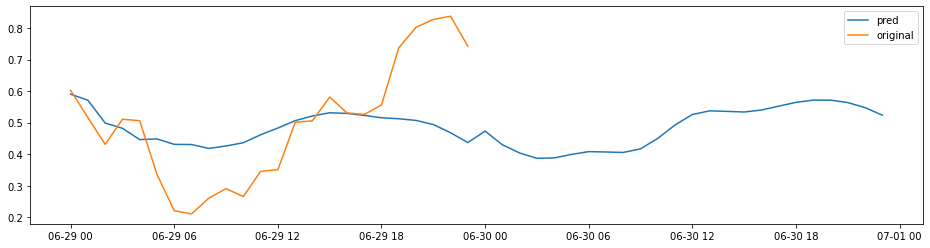

In [208]:
pred_f1_exog_1day = sarimax_pipeline_exog_f1.predict(48,pd.concat([pd.DataFrame(farm1.ws[-24:]),farm1_exog_test],axis=0))
plt.plot(pd.Series(pred_f1_exog_1day, index=farm1[-48:].index), label='pred')
plt.plot(farm1[-48:].wp, label='original')
plt.legend();

In [217]:
sarimax_pipeline_exog_f2 = Pipeline([  #The boxcox transform has been removed because it messes with the exogenous input
    ('arima', pm.AutoARIMA(trace=True,
                           suppress_warnings=True,
#                            m=1, 
                           method='nm',
                           maxiter=20,
                           
                          )
    )
])

sarimax_pipeline_exog_f2.fit(farm2_baseline_train,farm2_exog_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-2074.807, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2015.569, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2037.876, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2043.361, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2017.085, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-2077.658, Time=0.23 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-2050.008, Time=0.26 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2044.848, Time=0.21 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-2078.472, Time=0.30 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-2056.019, Time=0.28 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-2081.233, Time=0.32 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-2079.636, Time=0.36 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=-2069.303, Time=0.41 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-2064.946, Time=0.42 sec
 ARIMA(3,1,2)(0,0,0

Pipeline(steps=[('arima',
                 AutoARIMA(maxiter=20, method='nm', suppress_warnings=True,
                           trace=True))])

In [222]:
pred_exog_f2 = sarimax_pipeline_exog_f2.predict(24,farm2_exog_test)
mean_absolute_error(pred_exog_f2,farm2_baseline_test)


,ws
date,
2010-06-29 00:00:00,5.40
2010-06-29 01:00:00,4.25
2010-06-29 02:00:00,4.48
2010-06-29 03:00:00,4.95
2010-06-29 04:00:00,5.18


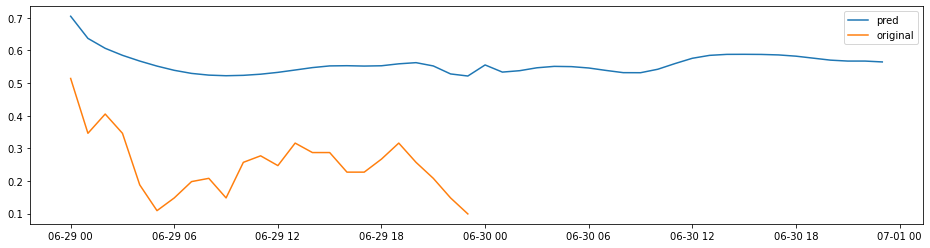

In [219]:
pred_f2_exog_1day = sarimax_pipeline_exog_f2.predict(48,pd.concat([pd.DataFrame(farm2.ws[-24:]),farm2_exog_test],axis=0))
plt.plot(pd.Series(pred_f2_exog_1day, index=farm2[-48:].index), label='pred')
plt.plot(farm2[-48:].wp, label='original')
plt.legend();

In [209]:
sarimax_pipeline_exog_f3 = Pipeline([  #The boxcox transform has been removed because it messes with the exogenous input
    ('arima', pm.AutoARIMA(trace=True,
                           suppress_warnings=True,
                           m=2, 
                           method='nm',
                           maxiter=20,
                           
                          )
    )
])

sarimax_pipeline_exog_f3.fit(farm3_baseline_train,farm3_exog_train)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[2] intercept   : AIC=-2935.030, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[2] intercept   : AIC=-2841.443, Time=0.14 sec
 ARIMA(1,1,0)(1,0,0)[2] intercept   : AIC=-2935.403, Time=0.17 sec
 ARIMA(0,1,1)(0,0,1)[2] intercept   : AIC=-2940.039, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[2]             : AIC=-2842.547, Time=0.19 sec
 ARIMA(0,1,1)(0,0,0)[2] intercept   : AIC=-2936.182, Time=0.16 sec
 ARIMA(0,1,1)(1,0,1)[2] intercept   : AIC=-2938.861, Time=0.24 sec
 ARIMA(0,1,1)(0,0,2)[2] intercept   : AIC=-2956.377, Time=0.47 sec
 ARIMA(0,1,1)(1,0,2)[2] intercept   : AIC=-2955.466, Time=0.46 sec
 ARIMA(0,1,0)(0,0,2)[2] intercept   : AIC=-2883.571, Time=0.33 sec
 ARIMA(1,1,1)(0,0,2)[2] intercept   : AIC=-2951.552, Time=0.48 sec
 ARIMA(1,1,0)(0,0,2)[2] intercept   : AIC=-2955.823, Time=0.35 sec
 ARIMA(0,1,1)(0,0,2)[2]             : AIC=-2958.396, Time=0.45 sec
 ARIMA(0,1,1)(0,0,1)[2]             : AIC=-2942.035, Time=0.26 sec
 ARIMA(0,1,1)(1,0,2

Pipeline(steps=[('arima',
                 AutoARIMA(m=2, maxiter=20, method='nm', suppress_warnings=True,
                           trace=True))])

In [210]:
pred_exog_f3 = sarimax_pipeline_exog_f3.predict(24,farm3_exog_test)
mean_absolute_error(pred_exog_f3,farm3_baseline_test)

0.10275959877773873

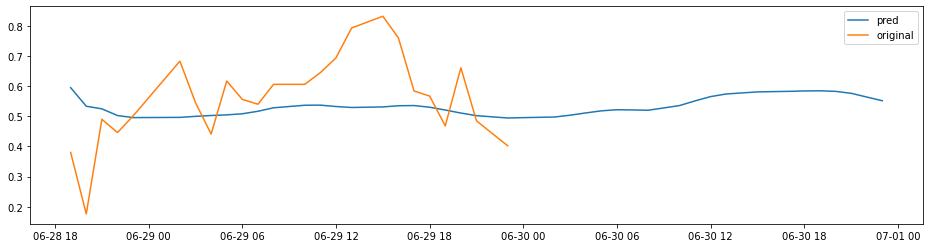

In [213]:
pred_f3_exog_1day = sarimax_pipeline_exog_f3.predict(48,pd.concat([pd.DataFrame(farm3.ws[-24:]),farm3_exog_test],axis=0))
plt.plot(pd.Series(pred_f3_exog_1day, index=farm3[-48:].index), label='pred')
plt.plot(farm3[-48:].wp, label='original')
plt.legend();